In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import tensorflow as tf
import librosa
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve
)

from tensorflow.keras import layers, models, Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Input, BatchNormalization, LSTM, RepeatVector,
    TimeDistributed
)
from tensorflow.keras.callbacks import EarlyStopping

2024-01-02 13:17:23.703801: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 13:17:23.756034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 13:17:25.604357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
current_datetime=datetime.datetime.now()
print(f"AutoEncoder last ran on: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

AutoEncoder last ran on: 2024-01-02 13:17:31


In [3]:
# Loading the audio files

def load_audio_files(path, label):
    audio_files = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.wav'):
            file_path = os.path.join(path, filename)
            audio, sample_rate = librosa.load(file_path, sr=None)
            audio_files.append(audio)
            labels.append(label)
    return audio_files, labels, sample_rate

normal_calf_path="Calf_Detection/Audio/Audio_Work_AE/normal_calf_subset"
abnormal_calf_path = "Calf_Detection/Audio/Audio_Work_AE/abnormal_calf_subset"

abnormal_audio, abnormal_labels, _ = load_audio_files(abnormal_calf_path, label=1)
normal_audio, normal_labels, sample_rate = load_audio_files(normal_calf_path, label=0)

In [4]:
# Feature Extraction:

# MFCCs (Power Spectrum)
def extract_mfccs(audio, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

# Spectral Features (spectral centroid, spectral roll-off, and spectral contrast):
def extract_spectral_features(audio, sample_rate):
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)[0]
    return np.mean(spectral_centroids), np.mean(spectral_rolloff), np.mean(spectral_contrast)

# Temporal Features ( zero-crossing rate and autocorrelation):
def extract_temporal_features(audio):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    autocorrelation = librosa.autocorrelate(audio)
    return np.mean(zero_crossing_rate), np.mean(autocorrelation)


In [5]:
# Data Augmentation:
def augment_audio(audio, sample_rate, noise_factor=0.005, shift_max=0.2):
    # Should experiment with Time Shifting, if needed
    augmented_audio = audio

    # Should experiment with different  noise levels
    noise = np.random.randn(len(augmented_audio))
    augmented_audio = augmented_audio + noise_factor * noise

    return augmented_audio

In [6]:
# Feature Extraction:

def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)

In [8]:
def enhanced_autoencoder_with_lstm(input_dim, timesteps, n_features):
    input_layer = Input(shape=(timesteps, n_features))

    # Encoder with LSTM
    encoder = LSTM(128, activation='relu', return_sequences=True)(input_layer)
    encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)

    # Repeat Vector
    repeat_vector = RepeatVector(timesteps)(encoder)

    # Decoder with LSTM
    decoder = LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    decoder = LSTM(128, activation='relu', return_sequences=True)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = TimeDistributed(Dense(n_features, activation='sigmoid'))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Print the shape of your data
print("Shape of X_train_scaled:", X_train_scaled.shape)

# Calculate the total number of elements
total_elements = np.prod(X_train_scaled.shape)
print("Total number of elements:", total_elements)

n_samples, n_features = X_train_scaled.shape

# Find suitable timesteps
for timesteps in range(1, n_samples + 1):
    if n_samples % timesteps == 0:
        reshaped_samples = n_samples // timesteps
        if reshaped_samples * timesteps * n_features == n_samples * n_features:
            print(f"Suitable timesteps: {timesteps}")
            break

# Reshaping for LSTM Input
timesteps = 1  # Should be adjusted as we scale.
n_features = normal_features.shape[1]
X_train_reshaped = X_train_scaled.reshape((-1, timesteps, n_features))
X_val_reshaped = X_val_scaled.reshape((-1, timesteps, n_features))

# Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder = enhanced_autoencoder_with_lstm(input_dim=n_features, timesteps=timesteps, n_features=n_features)
autoencoder.fit(
    X_train_reshaped, X_train_reshaped,
    epochs=400,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_reshaped, X_val_reshaped),
    callbacks=[early_stopping],
    verbose=0
)

Shape of X_train_scaled: (48, 18)
Total number of elements: 864
Suitable timesteps: 1


2024-01-02 13:26:54.482006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1071 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:b2:00.0, compute capability: 8.6


2024-01-02 13:26:58.927657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-02 13:26:59.027921: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1aa0031740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 13:26:59.027969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-02 13:26:59.035538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 13:26:59.071836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-02 13:26:59.140604: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 13:26:59.21877

In [9]:
# Combine normal and abnormal data for testing
X_test = abnormal_features
X_test_scaled = scaler.transform(X_test)

# Reshaping for LSTM Input
X_test_reshaped = X_test_scaled.reshape((-1, timesteps, n_features))
X_combined_test = np.concatenate((X_val_reshaped, X_test_reshaped))

# Prepare labels for combined test data
y_combined_test = np.concatenate((np.zeros(len(X_val_reshaped)), np.ones(len(X_test_reshaped))))  # 0 for normal, 1 for abnormal

def model_evaluation(autoencoder, X_test, y_test):
    reconstructed_test = autoencoder.predict(X_test)

    # Calculate MSE for each sample across all timesteps and features
    mse_test = np.mean(np.power(X_test - reconstructed_test, 2), axis=(1, 2))

    precisions, recalls, thresholds = precision_recall_curve(y_test, mse_test)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    optimal_predictions = (mse_test > optimal_threshold).astype(int)
    optimal_accuracy = accuracy_score(y_test, optimal_predictions)
    optimal_precision = precision_score(y_test, optimal_predictions)
    optimal_recall = recall_score(y_test, optimal_predictions)
    optimal_f1 = f1_score(y_test, optimal_predictions)

    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Accuracy: {optimal_accuracy}")
    print(f"Precision: {optimal_precision}")
    print(f"Recall: {optimal_recall}")
    print(f"F1 Score: {optimal_f1}")

    optimal_cm = confusion_matrix(y_test, optimal_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Optimal Confusion Matrix')
    plt.show()


2/2 [==============================] - 0s 4ms/step
Optimal Threshold: 1.8407930864778292
Accuracy: 0.21739130434782608
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/tmp/736186.tinygpu/ipykernel_113047/1681339387.py:19: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


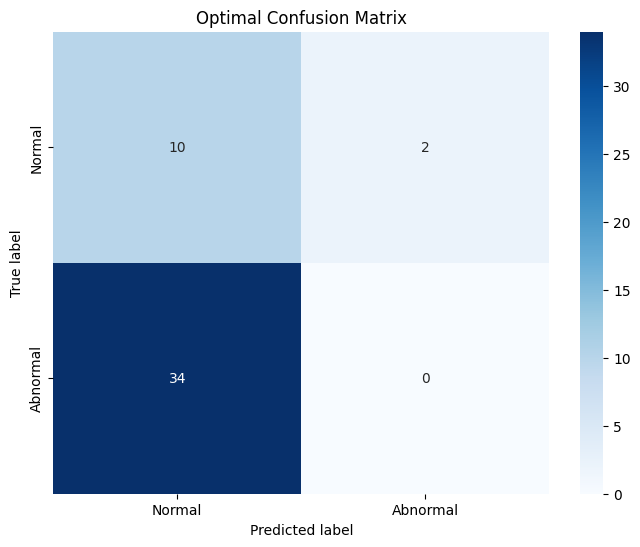

In [10]:
# Evaluate the model
model_evaluation(autoencoder, X_combined_test, y_combined_test)

# Save the model
autoencoder.save('Encoder_Model.keras')